<a href="https://colab.research.google.com/github/zia207/r-colab/blob/main/NoteBook/Machine_Learning/stack_ensemble_h2o_r.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Stack-Ensemble Model with H20 in R**

Zia Ahmed, University at Buffalo, NY



H2O\'s Stacked Ensemble method is a supervised ensemble machine learning algorithm that finds the optimal combination of a collection of different types of ML models using stacking. Like all supervised models in H2O, Stacked Ensemble supports regression, binary classification, and multiclass classification.

To create stacked ensembles with H2O in R, you can follow these general steps:

1.   **Set up the Ensemble:** Specify a list of L base algorithms (with a specific set of model parameters) and specify a meta-learning algorithm

2.   **Grid Search**: Find the best base model for each L-base algorithm using a hyperparameter grid search

3.  **Train L-base models**: Perform k-fold cross-validation on each learner and collect the cross-validated predicted values from each L algorithm.

4.   **Prediction**: The N cross-validated predicted values from each of the L algorithms can be combined to form a new N x L matrix. This matrix, along with the original response vector, is called the \"level-one\" data. (N = number of rows in the training set.

5.  T**rain with the Metalearner**: Train the metalearning algorithm on the level-one data. The \"ensemble model\" consists of the L base learning models and the metalearning model, which can then be used to generate predictions on a test set.

6.   **Predict with the stacked ensemble**: Once the stack ensemble is trained, you can use it to make predictions on new, unseen data.

7.  **Shutdown the H2O cluster**: After you have finished using H2O, it's good practice to shut down the H2O cluster by running **`h2o.shutdown()`**.

### Install rpy2

In [ ]:
!pip uninstall rpy2 -y
!pip install rpy2==3.5.1
%load_ext rpy2.ipython

### Mount Google Drive

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### Check amd Install Required R Packages

In [ ]:
%%R
pkg <- c('tidyverse','tidymodels', 'gridExtra', 'devtools', 'data.table', 'Hmisc','corrplot',
        'ggpmisc', 'plyr', 'Metrics','patchwork' )
new.packages <- pkg[!(pkg %in% installed.packages(lib='drive/My Drive/R/')[,"Package"])]
if(length(new.packages)) install.packages(new.packages, lib='drive/My Drive/R/')

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

also installing the dependencies ‘bitops’, ‘RCurl’


Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

also installing the dependencies ‘shape’, ‘future.apply’, ‘numDeriv’, ‘progressr’, ‘SQUAREM’, ‘Rcpp’, ‘diagram’, ‘lava’, ‘listenv’, ‘parallelly’, ‘prodlim’, ‘future’, ‘warp’, ‘iterators’, ‘lhs’, ‘DiceDesign’, ‘patchwork’, ‘globals’, ‘clock’, ‘gower’, ‘ipred’, ‘timeDate’, ‘furrr’, ‘slider’, ‘foreach’, ‘GPfit’, ‘modelenv’, ‘dials’, ‘hardhat’, ‘infer’, ‘modeldata’, ‘parsnip’, ‘recipes’, ‘rsample’, ‘tune’, ‘workflows’, ‘workflowsets’, ‘yardstick’


Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)



### Install H2O

In [ ]:
%%R
pkgs <- c("RCurl","jsonlite")
for (pkg in pkgs) {
  if (! (pkg %in% rownames(installed.packages(lib='drive/My Drive/R/')))) { install.packages(pkg) }
}
install.packages("h2o", type="source",lib='drive/My Drive/R/', repos=(c("http://h2o-release.s3.amazonaws.com/h2o/latest_stable_R")))

### Load Packages

In [ ]:
%%R
# set library path
.libPaths('drive/My Drive/R')
library(tidyverse)
library(tidymodels)
library(Metrics)
library(ggpmisc)
library(vip)
library(gridExtra)

### Data

The data use in this excersise could be found in my [Dropbox](https://www.dropbox.com/scl/fo/6cswerwra1k7qs6fzxieq/h?rlkey=6kqt1ztnkgrdt7cjmaqfkd7fd&dl=0) or [Github](https://github.com/zia207/r-colab/tree/main/Data/Machine_Learning) folder. Or you can load in directly in R using following comand.

In [8]:
%%R
urlfile = "https://github.com//zia207/r-colab/raw/main/Data/Machine_Learning/GP_all_data.csv"
mf<-read_csv(url(urlfile))
#mf<-read_csv("/content/drive/MyDrive/R_Website/Machine_Learning/Data/gp_soil_data_syn.csv")

Rows: 471 Columns: 21
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr  (4): STATE, COUNTY, NLCD_DES, FRG_DES
dbl (17): ID, STATE_ID, FIPS, x, y, SOC, ELEV, Aspect, Slope, TPI, K_Factor,...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


In [13]:
%%R
# Create a data-frame
df<-mf %>% dplyr::select(SOC, ELEV, Slope, Aspect, TPI, K_Factor, Silt_Clay, MAT, MAP,NDVI, NLCD, FRG)%>%
    glimpse()

Rows: 471
Columns: 12
$ SOC       <dbl> 7.256, 4.594, 5.995, 11.220, 5.388, 1.619, 3.842, 10.276, 0.…
$ ELEV      <dbl> 272.6797, 2261.7820, 2404.1121, 2281.4246, 277.6634, 2317.49…
$ Slope     <dbl> 1.429968, 4.874323, 6.680480, 7.745950, 2.923675, 2.635038, …
$ Aspect    <dbl> 185.0404, 222.3785, 183.5729, 173.1285, 168.1043, 193.8056, …
$ TPI       <dbl> 1.0744587, -1.4409482, 7.7656183, -3.2823703, -0.4226714, -1…
$ K_Factor  <dbl> 0.3255294, 0.2486000, 0.0590000, 0.2847475, 0.3750685, 0.249…
$ Silt_Clay <dbl> 77.16470, 40.66200, 53.73600, 46.83738, 62.83973, 38.42100, …
$ MAT       <dbl> 13.748117, 8.162200, 6.890750, 8.533788, 14.152466, 8.189600…
$ MAP       <dbl> 1099.3408, 410.5008, 568.7746, 391.4978, 1013.7034, 368.2008…
$ NDVI      <dbl> 0.6943141, 0.3705533, 0.6434158, 0.3530265, 0.7292835, 0.283…
$ NLCD      <dbl> 7, 4, 4, 4, 6, 5, 4, 4, 5, 4, 4, 6, 4, 4, 4, 5, 4, 5, 4, 5, …
$ FRG       <dbl> 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, …


### Data Preprocessing

#### Convert to factor

In [14]:
%%R
df$NLCD <- as.factor(df$NLCD)
df$FRG <- as.factor(df$FRG)

#### Data Split

In [15]:
%%R
set.seed(1245)   # for reproducibility
split_01 <- initial_split(df, prop = 0.8, strata = SOC)
train <- split_01 %>% training()
test <-  split_01 %>% testing()

#### Data Scaling

In [16]:
%%R
train[-c(1,11,12)] = scale(train[-c(1,11,12)])
test[-c(1,11,12)] = scale(test[-c(1,11,12)])

### Import h2o

In [ ]:
%%R
library(h2o)
h2o.init()
#disable progress bar for RMarkdown
h2o.no_progress()
# Optional: remove anything from previous session
h2o.removeAll()

### Import data to h2o cluster

In [18]:
%%R
h_df=as.h2o(df)
h_train = as.h2o(train)
h_test = as.h2o(test)

In [19]:
%%R
train.xy<- as.data.frame(h_train)
test.xy<- as.data.frame(h_test)

### Define response and predictors

In [20]:
%%R
y <- "SOC"
x <- setdiff(names(h_df), y)

## **Train Base-Learners with Grid Search**

### 1. **Generalized Linear Models (GLM)**

A generalized linear model (GLM) is a statistical framework that extends the traditional linear regression model to accommodate a broader range of response variables and model assumptions. The GLM allows for the response variable to follow a distribution other than the normal distribution, and allows for the relationship between the response variable and the predictor variables to be modeled using a nonlinear function.

In [21]:
%%R
# GLM Hyperprameter
glm_hyper_params <-list(
             alpha = c(0,0.25,0.5,0.75,1),
             lambda = c(1, 0.5, 0.1, 0.01, 0.001, 0.0001, 0.00001, 0))

# GLM Hyperprameter Grid Search
GLM_grid <- h2o.grid(
                  algorithm="glm",
                  grid_id = "glm_grid_IDs",
                  x= x,
                  y = y,
                  training_frame = h_train,
                  #validation_frame = h_valid,
                  standardize = TRUE,
                  nfolds=5,
                  keep_cross_validation_predictions = TRUE,
                  hyper_params = glm_hyper_params,
                  seed = 42)

# Get GLM Grid parameters
glm_get_grid <- h2o.getGrid("glm_grid_IDs",sort_by="RMSE",decreasing=FALSE)
glm_get_grid@summary_table[1,]

# Number of GLM models
length(GLM_grid@model_ids)

# The Best GLM Model
best_GLM <- h2o.getModel(glm_get_grid@model_ids[[1]])
summary(best_GLM)

Model Details:

H2ORegressionModel: glm
Model Key:  glm_grid_IDs_model_15 
GLM Model: summary
    family     link        regularization number_of_predictors_total
1 gaussian identity Lasso (lambda = 0.1 )                         19
  number_of_active_predictors number_of_iterations   training_frame
1                           6                    1 train_sid_9baa_3

H2ORegressionMetrics: glm
** Reported on training data. **

MSE:  13.82339
RMSE:  3.717982
MAE:  2.619295
RMSLE:  0.5055727
Mean Residual Deviance :  13.82339
R^2 :  0.4226326
Null Deviance :8978.288
Null D.o.F. :374
Residual Deviance :5183.771
Residual D.o.F. :368
AIC :2065.09



H2ORegressionMetrics: glm
** Reported on cross-validation data. **
** 5-fold cross-validation on training data (Metrics computed for combined holdout predictions) **

MSE:  14.79692
RMSE:  3.846677
MAE:  2.6804
RMSLE:  0.517457
Mean Residual Deviance :  14.79692
R^2 :  0.3819707
Null Deviance :9086.593
Null D.o.F. :374
Residual Deviance :5548.846


### **2. Distributaed Random Forest (DRF)**

RF in h20 is also referred to as a distributed random forest (DRF), which is a parallel implementation of Random Forest. In a DRF, individual trees are trained on a subset of the data rows and columns. This randomization helps to minimize overfitting and enhance model accuracy and stability. The individual tree predictions are then combined to form a final prediction.

In [27]:
%%R
# RF Hyper-parameters
RF_hyper_params <-list(
              ntrees  = seq(100, 5000, by = 100),
              max_depth=c(10,20,30,40,50),
              sample_rate=c(0.7, 0.8, 0.9, 1.0)
              )

# RF Hyper-parameters Search Criteria
RF_search_criteria <- list(strategy = "RandomDiscrete",
                        max_models = 100,
                        max_runtime_secs = 300,
                        stopping_tolerance = 0.001,
                        stopping_rounds = 2,
                        seed = 42)

# RF Grid Search
RF_grid <- h2o.grid(
                  algorithm="randomForest",
                  grid_id = "RF_grid_IDs",
                  x = x,
                  y = y,
                  training_frame = h_train,
                  #validation_frame = h_valid,
                  stopping_metric = "RMSE",
                  #fold_assignment ="Stratified",
                  nfolds=5,
                  keep_cross_validation_predictions = TRUE,
                  keep_cross_validation_models = TRUE,
                  hyper_params = RF_hyper_params,
                  search_criteria = RF_search_criteria,
                  seed = 42)

# Number RF models
length(RF_grid@model_ids)

# Get RF Grid parameters
RF_get_grid <- h2o.getGrid("RF_grid_IDs",
                           sort_by="RMSE",
                           decreasing=F)
# The Best RF model
best_RF <- h2o.getModel(RF_get_grid@model_ids[[1]])
best_RF

Model Details:

H2ORegressionModel: drf
Model ID:  RF_grid_IDs_model_5 
Model Summary: 
  number_of_trees number_of_internal_trees model_size_in_bytes min_depth
1            1472                     1472             5577083        14
  max_depth mean_depth min_leaves max_leaves mean_leaves
1        20   18.12568        281        317   296.89540


H2ORegressionMetrics: drf
** Reported on training data. **
** Metrics reported on Out-Of-Bag training samples **

MSE:  13.54631
RMSE:  3.680531
MAE:  2.665098
RMSLE:  0.5118363
Mean Residual Deviance :  13.54631



H2ORegressionMetrics: drf
** Reported on cross-validation data. **
** 5-fold cross-validation on training data (Metrics computed for combined holdout predictions) **

MSE:  13.64646
RMSE:  3.694112
MAE:  2.642237
RMSLE:  0.5101867
Mean Residual Deviance :  13.64646


Cross-Validation Metrics Summary: 
                            mean       sd cv_1_valid cv_2_valid cv_3_valid
mae                     2.636468 0.199784   2.806008   2

### **3. Gradient Boosting Machine (GBM)**

Gradient Boosting Machine (GBM) is a powerful and popular supervised learning algorithm used for both regression and classification tasks. It belongs to the family of ensemble methods, which combine multiple weak learners to form a stronger model. The idea behind gradient boosting is to iteratively improve a model's predictions by fitting a new model to the residuals or errors of the previous models.

Whereas random forests build an ensemble of deep independent trees, GBMs build an ensemble of shallow and weak successive trees with each tree learning and improving on the previous. When combined, these many weak successive trees produce a powerful "committee" that are often hard to beat with other algorithms.

In [28]:
%%R
# GBM Hyper-parameters
GBM_hyper_params = list( ntrees = c(100,500, 1000, 5000),
                     max_depth = c(2,5,8),
                     min_rows = c(8,10, 12),
                     learn_rate = c(0.001,0.05,0.06),
                     sample_rate = c(0.4,0.5,0.6, 0.7),
                     col_sample_rate = c(0.4,0.5,0.6),
                     col_sample_rate_per_tree = c(0.4,0.5,0.6))

# GBM Hyper-parameters Search Criteria
GBM_search_criteria <- list(strategy = "RandomDiscrete",
                        max_models = 20,
                        max_runtime_secs = 300,
                        stopping_tolerance = 0.001,
                        stopping_rounds = 2,
                        seed = 42)

# GBM Hyper-parameters Grid Search
GBM_grid <- h2o.grid(
                  algorithm="gbm",
                  grid_id = "GBM_grid_ID",
                  x= x,
                  y = y,
                  training_frame = h_train,
                  #validation_frame = h_valid,
                  distribution ="AUTO",
                  stopping_metric = "RMSE",
                  #fold_assignment ="Stratified",
                  nfolds=5,
                  keep_cross_validation_predictions = TRUE,
                  keep_cross_validation_models = TRUE,
                  hyper_params = GBM_hyper_params,
                  search_criteria = GBM_search_criteria,
                  seed = 42)

# Number GBM models
length(GBM_grid@model_ids)

# Get GBM Grid parameters
GBM_get_grid <- h2o.getGrid("GBM_grid_ID",
                           sort_by="RMSE",
                           decreasing=F)
#  the Best GBM Model
best_GBM <- h2o.getModel(GBM_get_grid@model_ids[[1]])
best_GBM

Model Details:

H2ORegressionModel: gbm
Model ID:  GBM_grid_ID_model_13 
Model Summary: 
  number_of_trees number_of_internal_trees model_size_in_bytes min_depth
1            5000                     5000              528722         2
  max_depth mean_depth min_leaves max_leaves mean_leaves
1         2    2.00000          3          4     3.61260


H2ORegressionMetrics: gbm
** Reported on training data. **

MSE:  10.19296
RMSE:  3.192642
MAE:  2.302968
RMSLE:  0.4633825
Mean Residual Deviance :  10.19296



H2ORegressionMetrics: gbm
** Reported on cross-validation data. **
** 5-fold cross-validation on training data (Metrics computed for combined holdout predictions) **

MSE:  14.32359
RMSE:  3.784652
MAE:  2.695643
RMSLE:  0.5244795
Mean Residual Deviance :  14.32359


Cross-Validation Metrics Summary: 
                            mean       sd cv_1_valid cv_2_valid cv_3_valid
mae                     2.681142 0.276308   2.826907   3.072784   2.603828
mean_residual_deviance 14.284904 2

## **4. eXtreme Gradient Boosting (XGBoost)**

The XGBoost algorithm works by building a series of decision trees, where each subsequent tree tries to correct the errors of the previous tree. The algorithm also employs a gradient-based optimization approach to find the optimal set of parameters for each decision tree.

In [29]:
%%R
# hyper parameters
XGBoost_hyper_params = list( ntrees = seq(50,500,50),
                     max_depth = seq(1,120,1),
                     min_rows = c(1,5,10,20,50,100),
                     learn_rate = seq(0.001,0.01,0.001),
                     sample_rate = seq(0.3,1,0.05),
                     col_sample_rate = seq(0.3,1,0.05),
                     col_sample_rate_per_tree = seq(0.3,1,0.05))

# Search Criteria
XGBoost_search_criteria <- list(strategy = "RandomDiscrete",
                        max_models = 200,
                        max_runtime_secs = 300,
                        stopping_tolerance = 0.001,
                        stopping_rounds = 2,
                        seed = 1345767)
# Gird Search
XGBoost_grid <- h2o.grid(
                  algorithm="xgboost",
                  grid_id = "XGBoost_grid_ID",
                  x= x,
                  y = y,
                  training_frame = h_train,
                  stopping_metric = "rmse",
                  #fold_assignment ="Stratified",
                  nfolds=10,
                  keep_cross_validation_predictions = TRUE,
                  keep_cross_validation_models = TRUE,
                  hyper_params = XGBoost_hyper_params,
                  search_criteria = XGBoost_search_criteria,
                  seed = 42)

# Number XGBoost models
length(XGBoost_grid@model_ids)

# Get XGBoost Grid parameters
XGBoost_get_grid <- h2o.getGrid("XGBoost_grid_ID",
                           sort_by="RMSE",
                           decreasing=F)
#  the Best XGBoost Model
best_XGBoost <- h2o.getModel(XGBoost_get_grid@model_ids[[1]])
best_XGBoost

Model Details:

H2ORegressionModel: xgboost
Model ID:  XGBoost_grid_ID_model_25 
Model Summary: 
  number_of_trees
1             350


H2ORegressionMetrics: xgboost
** Reported on training data. **

MSE:  7.19878
RMSE:  2.683054
MAE:  1.756419
RMSLE:  0.3491602
Mean Residual Deviance :  7.19878



H2ORegressionMetrics: xgboost
** Reported on cross-validation data. **
** 10-fold cross-validation on training data (Metrics computed for combined holdout predictions) **

MSE:  14.48835
RMSE:  3.806357
MAE:  2.634807
RMSLE:  0.5064981
Mean Residual Deviance :  14.48835


Cross-Validation Metrics Summary: 
                            mean       sd cv_1_valid cv_2_valid cv_3_valid
mae                     2.614362 0.485994   3.038212   3.256584   3.028240
mean_residual_deviance 14.140247 6.373582  27.264172  18.903288  13.860534
mse                    14.140247 6.373582  27.264172  18.903288  13.860534
r2                      0.388399 0.270300   0.406661  -0.319179   0.386317
residual_deviance 

### **5. Deep Neural Network (DNN)**

H2O’s Deep Learning is based on a multi-layer feedforward artificial neural network that is trained with stochastic gradient descent using back-propagation. The network can contain a large number of hidden layers consisting of neurons with tanh, rectifier, and maxout activation functions. Advanced features such as adaptive learning rate, rate annealing, momentum training, dropout, L1 or L2 regularization, checkpointing, and grid search enable high predictive accuracy. Each compute node trains a copy of the global model parameters on its local data with multi-threading (asynchronously) and contributes periodically to the global model via model averaging across the network.

In [30]:
%%R
# DNN Hyper-parameters
DNN_hyper_params <- list(
                     activation = c("Rectifier",
                                    "Maxout",
                                    "Tanh",
                                    "RectifierWithDropout",
                                    "MaxoutWithDropout",
                                    "TanhWithDropout"),
                     hidden = list( c(50, 50, 50, 50),
                                   c(100, 100, 100), c(200, 200, 200)),
                     epochs = c(50, 100, 200, 500),
                     l1 = c(0, 0.00001, 0.0001),
                     l2 = c(0, 0.00001, 0.0001),
                     rate = c(0, 01, 0.005, 0.001),
                     rate_decay = c(0.5, 1.0, 1.5),
                     rate_annealing = c(1e-5, 1e-6, 1e-5),
                     rho = c(0.9, 0.95, 0.99, 0.999),
                     epsilon = c(1e-06, 1e-08, 1e-09),
                     momentum_start = c(0, 0.5),
                     momentum_stable = c(0.99, 0.5, 0),
                     regression_stop = c(1e-05, 1e-06,1e-07),
                     input_dropout_ratio = c(0, 0.0001, 0.001),
                     max_w2 = c(10, 100, 1000, 3.4028235e+38)
                     )

# DNN Hyper-parameters Search criteria
DNN_search_criteria <- list(strategy = "RandomDiscrete",
                        max_models = 100,
                        max_runtime_secs = 300,
                        stopping_tolerance = 0.001,
                        stopping_rounds = 3,
                        seed = 1345767)

# DNN Hyper-parameters Grid Search
DNN_grid <- h2o.grid(
                  algorithm="deeplearning",
                  grid_id = "DNN_grid_IDs",
                  x= x,
                  y = y,
                  standardize = TRUE,
                  shuffle_training_data = TRUE,
                  training_frame = h_train,
                  #validation_frame = h_valid,
                  distribution ="AUTO",
                  stopping_metric = "RMSE",
                  nfolds= 5,
                  keep_cross_validation_predictions = TRUE,
                  keep_cross_validation_models = TRUE,
                  hyper_params = DNN_hyper_params,
                  search_criteria = DNN_search_criteria,
                  seed = 42)

# Number DNN models
length(DNN_grid@model_ids)

# Get DNN Grid parameters
DNN_get_grid <- h2o.getGrid("DNN_grid_IDs",
                           sort_by="RMSE",
                           decreasing=F)
#The Best DNN model
best_DNN <- h2o.getModel(DNN_get_grid@model_ids[[1]])
best_DNN

Model Details:

H2ORegressionModel: deeplearning
Model ID:  DNN_grid_IDs_model_1 
Status of Neuron Layers: predicting SOC, regression, gaussian distribution, Quadratic loss, 22,501 weights/biases, 272.2 KB, 19,697 training samples, mini-batch size 1
  layer units        type dropout       l1       l2 mean_rate rate_rms momentum
1     1    21       Input  0.10 %       NA       NA        NA       NA       NA
2     2   100 TanhDropout 50.00 % 0.000100 0.000010  0.094333 0.282138 0.000000
3     3   100 TanhDropout 50.00 % 0.000100 0.000010  0.004738 0.004002 0.000000
4     4   100 TanhDropout 50.00 % 0.000100 0.000010  0.010781 0.048108 0.000000
5     5     1      Linear      NA 0.000100 0.000010  0.000347 0.000101 0.000000
  mean_weight weight_rms mean_bias bias_rms
1          NA         NA        NA       NA
2    0.000822   0.137732  0.002965 0.051917
3    0.000559   0.102039 -0.002017 0.096587
4    0.001133   0.097662  0.005839 0.047680
5   -0.013204   0.118152  0.082533 0.000000


H2OR

## **Stack-Ensemble Model: The Best of Families**

In [32]:
%%R
# rf-parameters
rf_params <-   list(
                    ntrees = 2000,
                    max_depth =25,
                    sample_rate = 0.8,
                    stopping_tolerance = 0.001,
                    stopping_rounds = 3,
                    stopping_metric = "RMSE")


stack_best <-h2o.stackedEnsemble(
                               model_id = "stack_RF_ID",
                               x= x,
                               y = y,
                               training_frame = h_train,
                               #validation_frame = h_valid,
                               base_models = list(best_GLM,
                                                  best_RF,
                                                  best_GBM,
                                                  best_XGBoost,
                                                  best_DNN
                                                  ),
                               metalearner_algorithm = "drf",
                               metalearner_params = rf_params,
                               metalearner_nfolds = 5,
                               seed = 42
                               )
stack_best

Model Details:

H2ORegressionModel: stackedensemble
Model ID:  stack_RF_ID 
Model Summary for Stacked Ensemble: 
                                         key
1                          Stacking strategy
2       Number of base models (used / total)
3           # GBM base models (used / total)
4       # XGBoost base models (used / total)
5           # GLM base models (used / total)
6           # DRF base models (used / total)
7  # DeepLearning base models (used / total)
8                      Metalearner algorithm
9         Metalearner fold assignment scheme
10                        Metalearner nfolds
11                   Metalearner fold_column
12        Custom metalearner hyperparameters
                                                                                                                                                                  value
1                                                                                                                                     

#### Prediction

In [33]:
%%R
stack.test.best<-as.data.frame(h2o.predict(object = stack_best, newdata = h_test))
test.xy$Stack_SOC_best<-stack.test.best$predict

In [35]:
%%R
RMSE.best<- Metrics::rmse(test.xy$SOC, test.xy$Stack_SOC_best)
MAE.best<- Metrics::mae(test.xy$SOC, test.xy$Stack_SOC_best)

# Print results
paste0("RMSE: ", round(RMSE.best,2))
paste0("MAE: ", round(MAE.best,2))

[1] "MAE: 3.19"


`geom_smooth()` using formula = 'y ~ x'


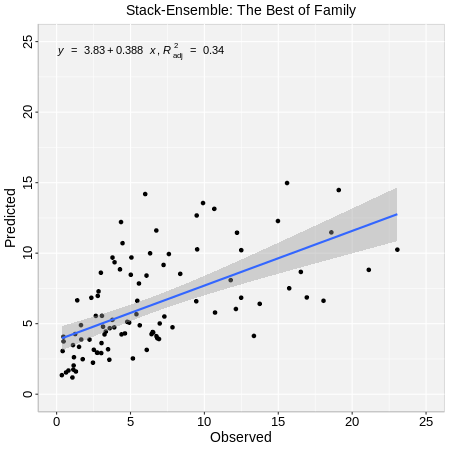

In [37]:
%%R -w 450 -h 450 -u px

formula<-y~x

ggplot(test.xy, aes(SOC,Stack_SOC_best)) +
  geom_point() +
  geom_smooth(method = "lm")+
  stat_poly_eq(use_label(c("eq", "adj.R2")), formula = formula) +
  ggtitle("Stack-Ensemble: The Best of Family") +
  xlab("Observed") + ylab("Predicted") +
  scale_x_continuous(limits=c(0,25), breaks=seq(0, 25, 5))+
  scale_y_continuous(limits=c(0,25), breaks=seq(0, 25, 5)) +
  # Flip the bars
  theme(
    panel.background = element_rect(fill = "grey95",colour = "gray75",size = 0.5, linetype = "solid"),
    axis.line = element_line(colour = "grey"),
    plot.title = element_text(size = 14, hjust = 0.5),
    axis.title.x = element_text(size = 14),
    axis.title.y = element_text(size = 14),
    axis.text.x=element_text(size=13, colour="black"),
    axis.text.y=element_text(size=13,angle = 90,vjust = 0.5, hjust=0.5, colour='black'))

## **Stack-Ensemble Model - All Models**

In [38]:
%%R
all_01 = append(GLM_grid@model_ids, RF_grid@model_ids)
all_02<-append(all_01, XGBoost_grid@model_ids)
all_03<-append(all_02,DNN_grid@model_ids)
all_04<-append(all_03,GBM_grid@model_ids)
length(all_04)

[1] 113


In [39]:
%%R
stack_all<- h2o.stackedEnsemble(
                               model_id = "stack_Model_ALL_IDs",
                               x= x,
                               y = y,
                               training_frame = h_train,
                               base_models = all_04,
                               metalearner_algorithm = "drf",
                               metalearner_nfolds = 5,
                               metalearner_params = rf_params,
                               keep_levelone_frame = TRUE,
                               seed=123)
stack_all

Model Details:

H2ORegressionModel: stackedensemble
Model ID:  stack_Model_ALL_IDs 
Model Summary for Stacked Ensemble: 
                                         key
1                          Stacking strategy
2       Number of base models (used / total)
3           # GBM base models (used / total)
4       # XGBoost base models (used / total)
5           # GLM base models (used / total)
6           # DRF base models (used / total)
7  # DeepLearning base models (used / total)
8                      Metalearner algorithm
9         Metalearner fold assignment scheme
10                        Metalearner nfolds
11                   Metalearner fold_column
12        Custom metalearner hyperparameters
                                                                                                                                                                  value
1                                                                                                                             

##### Prediction

In [40]:
%%R
stack.test.all<-as.data.frame(h2o.predict(object = stack_all, newdata = h_test))
test.xy$Stack_SOC_all<-stack.test.all$predict

In [41]:
%%R
RMSE.all<- Metrics::rmse(test.xy$SOC, test.xy$Stack_SOC_all)
MAE.all<- Metrics::mae(test.xy$SOC, test.xy$Stack_SOC_all)

# Print results
paste0("RMSE: ", round(RMSE.all,2))
paste0("MAE: ", round(MAE.all,2))

[1] "MAE: 2.91"


`geom_smooth()` using formula = 'y ~ x'


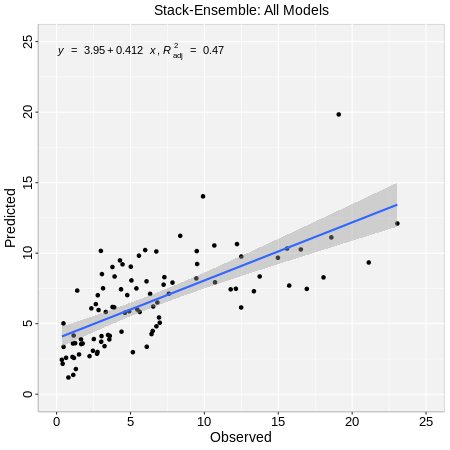

In [42]:
%%R -w 450 -h 450 -u px
formula<-y~x
ggplot(test.xy, aes(SOC,Stack_SOC_all)) +
  geom_point() +
  geom_smooth(method = "lm")+
  stat_poly_eq(use_label(c("eq", "adj.R2")), formula = formula) +
  ggtitle("Stack-Ensemble: All Models") +
  xlab("Observed") + ylab("Predicted") +
  scale_x_continuous(limits=c(0,25), breaks=seq(0, 25, 5))+
  scale_y_continuous(limits=c(0,25), breaks=seq(0, 25, 5)) +
  # Flip the bars
  theme(
    panel.background = element_rect(fill = "grey95",colour = "gray75",size = 0.5, linetype = "solid"),
    axis.line = element_line(colour = "grey"),
    plot.title = element_text(size = 14, hjust = 0.5),
    axis.title.x = element_text(size = 14),
    axis.title.y = element_text(size = 14),
    axis.text.x=element_text(size=13, colour="black"),
    axis.text.y=element_text(size=13,angle = 90,vjust = 0.5, hjust=0.5, colour='black'))

### Further Reading

1. [Stacked Ensembles](https://docs.h2o.ai/h2o/latest-stable/h2o-docs/data-science/stacked-ensembles.html)

2. [Chapter 15 Stacked Models](https://bradleyboehmke.github.io/HOML/stacking.html)